In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
table = Table.read('data/247548566.dat', format='ascii.fast_no_header', names=['JD', 'Flux', "Err"])
table["JD"] += 2454833

fit = np.polyfit(table['JD'] - table['JD'].mean(), table['Flux'], 1)
flux = table['Flux'] / np.polyval(fit, table['JD'] - table['JD'].mean())
error = table['Err'] / np.polyval(fit, table['JD'] - table['JD'].mean())


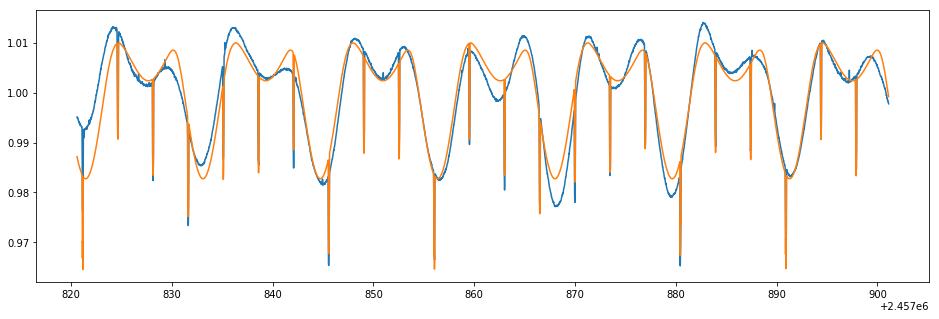

In [7]:
fig, ax = plt.subplots(figsize=(16, 5))
stsp = Table.read('L_lcout.txt', format='ascii.fast_no_header')
stsp_time = stsp['col1']
stsp_flux = stsp['col4']
plt.plot(table['JD'], flux/flux.mean())
plt.plot(stsp_time, stsp_flux/stsp_flux.mean())
plt.show()

In [8]:
import sys
sys.path.insert(0, '/Users/bmmorris/git/gravdark/')
sys.path.insert(0, '/Users/bmmorris/git/libra/')
from libra import transit_duration
import batman
from gravdark import LightCurve, TransitLightCurve

params = batman.TransitParams()
params.per = 3.4878840
params.t0 = 7824.65336 + 2450000
params.inc = 86.99
params.ecc = 0
params.w = 90
params.a = 9.43

q1 = 0.29
q2 = 0.48
u1 = 2*np.sqrt(q1)*q2
u2 = np.sqrt(q1)*(1 - 2*q2)
params.u = [u1, u2]
params.rp = 0.1305
params.limb_dark = 'quadratic'
duration = transit_duration(params)
params.duration = duration

lc = LightCurve(table['JD'], flux)
transits = LightCurve(**lc.mask_out_of_transit(params, oot_duration_fraction=2)).get_transit_light_curves(params)

model_lc = LightCurve(stsp_time, stsp_flux)
model_transits = LightCurve(**model_lc.mask_out_of_transit(params, oot_duration_fraction=2)).get_transit_light_curves(params)

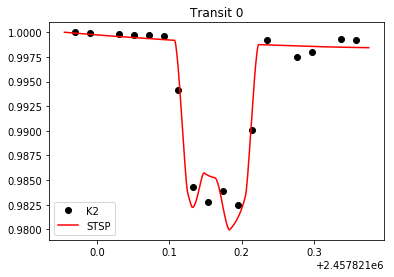

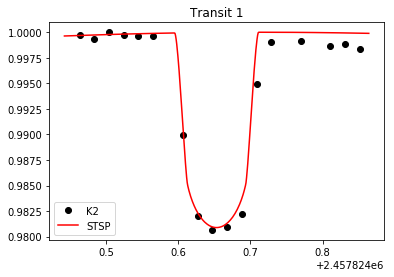

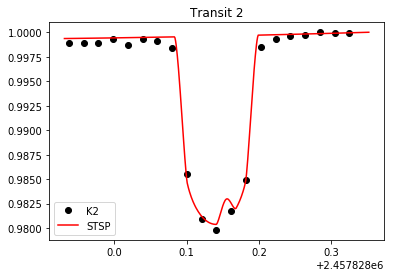

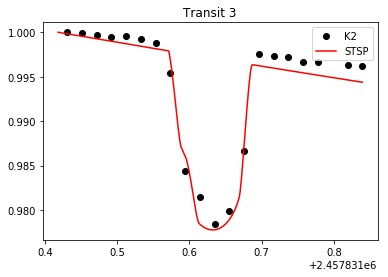

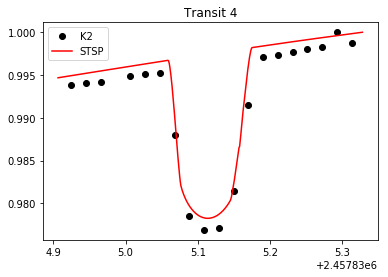

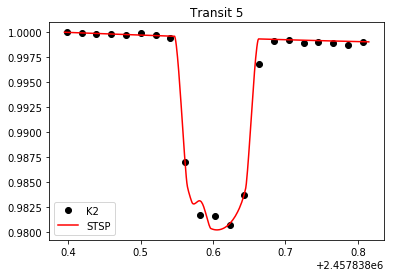

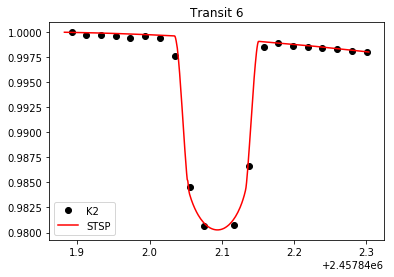

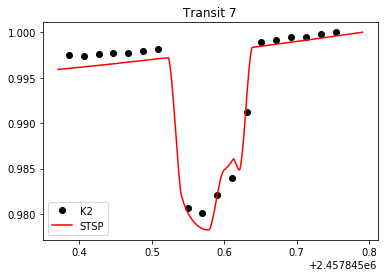

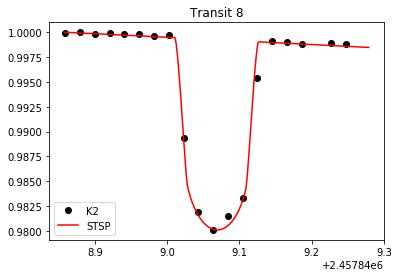

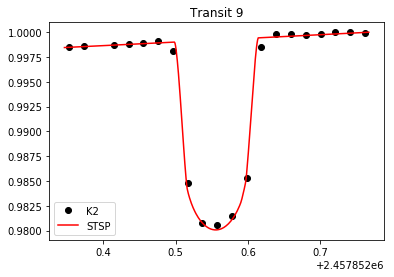

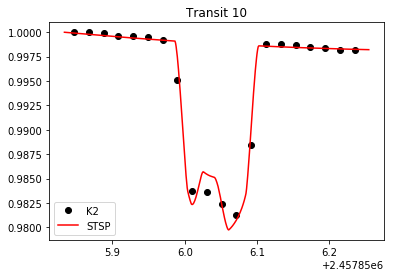

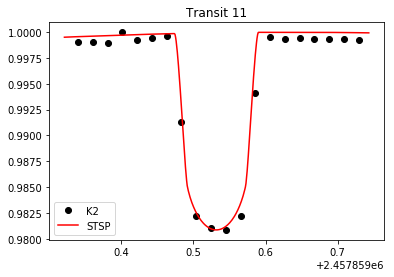

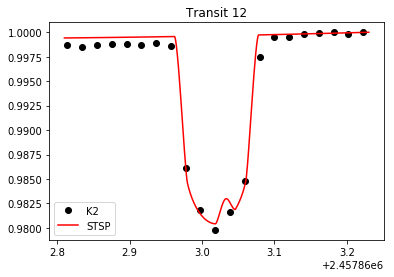

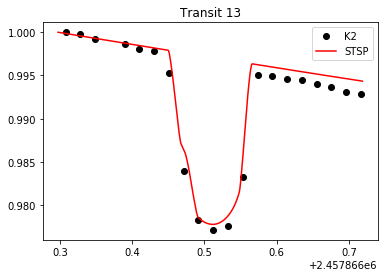

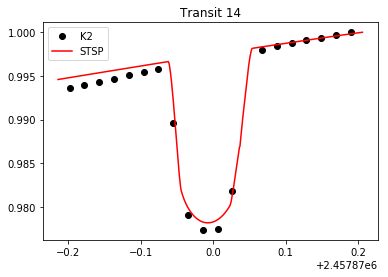

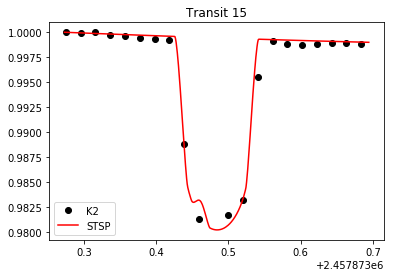

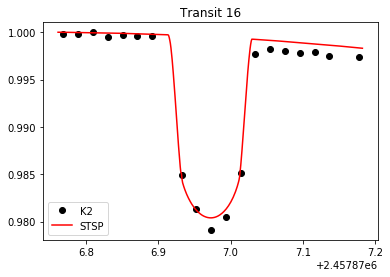

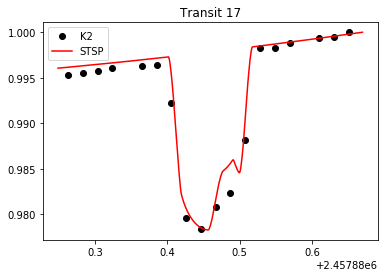

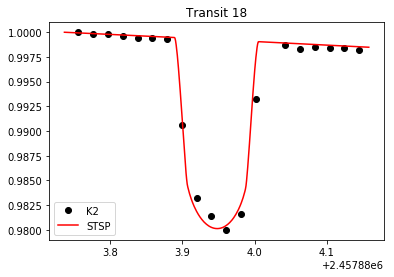

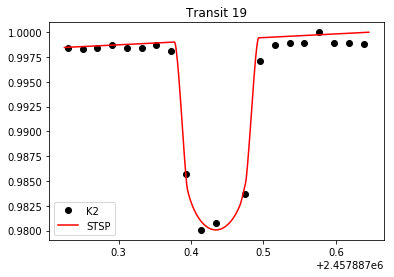

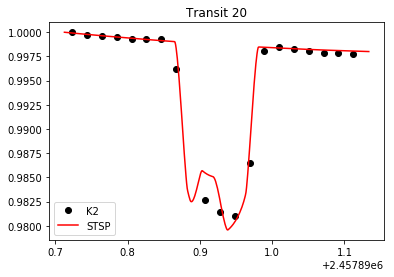

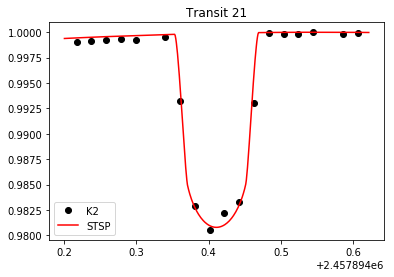

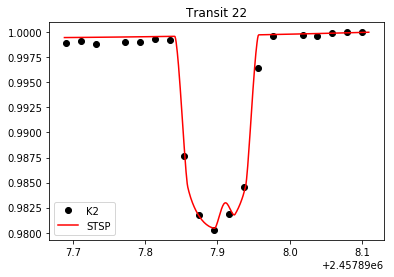

In [9]:
for i, transit, model in zip(range(len(transits)), transits, model_transits):
    plt.title('Transit {0}'.format(i))
    plt.plot(transit.times.jd, transit.fluxes/transit.fluxes.max(), 'ko', label='K2')
    plt.plot(model.times.jd, model.fluxes/model.fluxes.max(), color='r', label='STSP')
    plt.legend()
    plt.show()

In [10]:
!cat s.in

#PLANET PROPERTIES
1			; Number of planets -- (if there are more than 1 planet, then the set of 8 planet properties are repeated)
2457824.65336			; T0, epoch         (middle of first transit) in days.
3.4878840		; Planet Period      (days)
0.01703025		; (Rp/Rs)^2         (Rplanet / Rstar )^ 2
0.08434480			; Duration (days)   (physical duration of transit, not used)
0.49			; Impact parameter  (0= planet cross over equator)
86.99			; Inclination angle of orbit (90 deg = planet crosses over equator)
0.0			; Lambda of orbit (0 deg = orbital axis along z-axis)
0.0			; ecosw
0.0			; esinw
#STAR PROPERTIES
1.0		; Mean Stellar density (Msun/Rsun^3)
11.64			; Stellar Rotation period (days)
5576			; Stellar Temperature
0.0			; Stellar metallicity
13.9			; Tilt of the rotation axis of the star down from z-axis (degrees)
0 0.560057 0 -0.02154	; Limb darkening (4 coefficients)
40			; number of rings for limb darkening appoximation
#SPOT PROPERTIES
2				; number of spots
0.70				; fractional lightne

In [11]:
mcmc_results = Table.read('s_mcmc.txt', format='ascii.fast_no_header', 
                          names='1 2 3 chi2 r1 theta1 phi1 r2 theta2 phi2 max'.split(), 
                          data_start=0)

Text(0,0.5,'latitude')

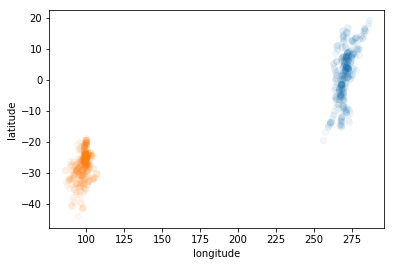

In [22]:
plt.scatter(np.degrees(mcmc_results['phi1']), np.degrees(np.pi/2 - mcmc_results['theta1']), alpha=0.05)
plt.scatter(np.degrees(mcmc_results['phi2']), np.degrees(np.pi/2 - mcmc_results['theta2']), alpha=0.05)
plt.xlabel('longitude')
plt.ylabel('latitude')

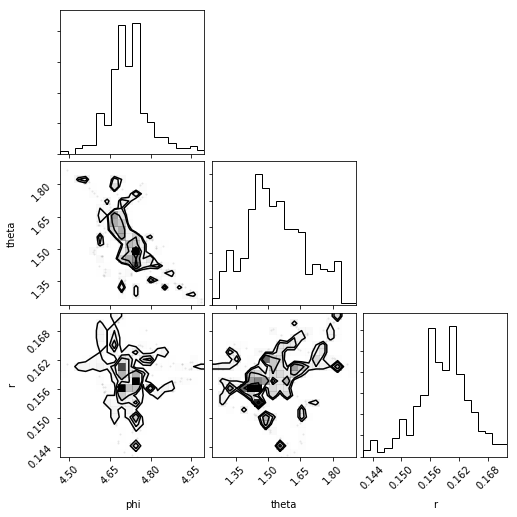

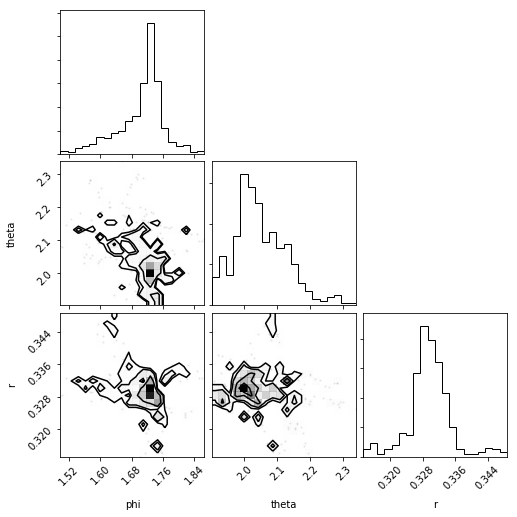

In [16]:
from corner import corner

# spot1 = mcmc_results['phi1'] > 4.5
corner(np.vstack([mcmc_results['phi1'], mcmc_results['theta1'], mcmc_results['r1']]).T, labels='phi theta r'.split())
plt.show()


# spot2 = mcmc_results['theta2'] > 2
corner(np.vstack([mcmc_results['phi2'], mcmc_results['theta2'], mcmc_results['r2']]).T, labels='phi theta r'.split())
plt.show()